In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)): 
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [4]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i]) 
        dataY.append(d_y[i + fore_cast,:])
    
    return np.array(dataX), np.array(dataY)

In [5]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\TH\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [6]:
#inclined_files = ['SKS_2_I.xlsx',  'SKS_3_I.xlsx',  'SKS_4_I.xlsx','SKS_5_I.xlsx', 'SD_2_I.xlsx',  'SD_3_I.xlsx',  'SD_4_I.xlsx','SD_5_I.xlsx']
file_name = ['TH_4_I.xls', 'TH_2_I.xls', 'TH_3_I.xls']

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path + file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)


In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177915 entries, 0 to 177914
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      177915 non-null  float64
 1   l_ph_ank      177915 non-null  float64
 2   l_ph_fo       177915 non-null  float64
 3   r_ph_hip      177915 non-null  float64
 4   r_ph_ank      177915 non-null  float64
 5   r_ph_fo       177915 non-null  float64
 6   n_lgrf        177915 non-null  float64
 7   n_r_grf       177915 non-null  float64
 8   n_lcop        177915 non-null  float64
 9   n_rcop        177915 non-null  float64
 10  perc_new      177915 non-null  float64
 11  st_sw_phase   177915 non-null  int64  
 12  strike_frame  177915 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 17.6 MB


In [10]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table
        

,l_ph_hip,l_ph_ank,l_ph_fo,r_ph_hip,r_ph_ank,r_ph_fo,n_lgrf,n_r_grf,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.013270,0.521355,0.058456,0.453265,0.808200,0.042480,0.035622,0.927779,0.033225,0.000050,0.000000,1,1
1,0.010924,0.511150,0.067066,0.449764,0.805368,0.040841,0.057092,0.920073,0.038450,0.000055,0.531915,1,2
2,0.008436,0.501568,0.075292,0.446400,0.803108,0.038816,0.084019,0.907231,0.043909,0.000058,1.063830,1,3
3,0.005811,0.492637,0.083024,0.443150,0.801333,0.036420,0.116295,0.888997,0.049512,0.000058,1.595745,1,4
4,0.003054,0.484363,0.090178,0.439985,0.799984,0.033668,0.153317,0.865200,0.055141,0.000057,2.127660,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177072,0.023919,0.583897,0.008558,0.451182,0.902190,0.031392,0.000000,0.852887,0.009759,0.000053,97.209302,1,210
177073,0.022709,0.575548,0.014431,0.450262,0.878289,0.032293,0.000000,0.857703,0.012699,0.000051,97.674419,1,211
177074,0.021361,0.567000,0.020613,0.449435,0.859827,0.033000,0.000000,0.860374,0.016020,0.000047,98.139535,1,212
177075,0.019872,0.558330,0.027046,0.448671,0.845535,0.033483,0.021364,0.860502,0.019722,0.000044,98.604651,1,213


In [11]:
source_table = source_table.drop(["n_lgrf","n_r_grf", "l_ph_ank", "r_ph_ank" ], axis = 1)
source_table

,l_ph_hip,l_ph_fo,r_ph_hip,r_ph_fo,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.013270,0.058456,0.453265,0.042480,0.033225,0.000050,0.000000,1,1
1,0.010924,0.067066,0.449764,0.040841,0.038450,0.000055,0.531915,1,2
2,0.008436,0.075292,0.446400,0.038816,0.043909,0.000058,1.063830,1,3
3,0.005811,0.083024,0.443150,0.036420,0.049512,0.000058,1.595745,1,4
4,0.003054,0.090178,0.439985,0.033668,0.055141,0.000057,2.127660,1,5
...,...,...,...,...,...,...,...,...,...
177072,0.023919,0.008558,0.451182,0.031392,0.009759,0.000053,97.209302,1,210
177073,0.022709,0.014431,0.450262,0.032293,0.012699,0.000051,97.674419,1,211
177074,0.021361,0.020613,0.449435,0.033000,0.016020,0.000047,98.139535,1,212
177075,0.019872,0.027046,0.448671,0.033483,0.019722,0.000044,98.604651,1,213


In [12]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [13]:
data_y = y.values.reshape(-1,2)

In [14]:
type(data_y)

numpy.ndarray

In [15]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25, 
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [16]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)


(132796, 10, 8)
(132796, 2)
(44259, 10, 8)
(44259, 2)


In [17]:
train_x.shape

(132796, 10, 8)

In [18]:
n1=validation_x.shape[0]
val_x=validation_x[1:int(n1/10),:]
val_y=validation_y[1:int(n1/10),:]
print(val_x.shape)
print(val_y.shape)

(4424, 10, 8)
(4424, 2)


In [19]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.005
	epochs_drop = 10
	lrate=initial_lrate - 0.00001 
	# lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [20]:
lr = 0.001
epochs = 20
batch = 128

serie_size = train_x.shape[1]
n_features = train_x.shape[2]
enc_dec_1 = Sequential()
enc_dec_1.add(InputLayer((10, train_x.shape[2])))
enc_dec_1.add(Conv1D(filters=32, kernel_size=3,strides=1,
    activation='relu', padding='same'))            
enc_dec_1.add(AveragePooling1D(pool_size=3))
# enc_dec_1.add(RepeatVector(10))

enc_dec_1.add(LSTM(32,  return_sequences=True))
enc_dec_1.add(LSTM(16,  activation='relu'))
enc_dec_1.add(L.RepeatVector((10)))
enc_dec_1.add(LSTM(16,  return_sequences=True))
enc_dec_1.add(LSTM(32,  activation='relu', return_sequences=True))
enc_dec_1.add(L.TimeDistributed(L.Dense(n_features)))


enc_dec_1.summary()
adam = optimizers.Adam(lr)
enc_dec_1.compile(loss='mse', optimizer=adam)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            800       
                                                                 
 average_pooling1d (AverageP  (None, 3, 32)            0         
 ooling1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 3, 32)             8320      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 10, 16)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 10, 16)            2

In [21]:
encoder_decoder_history = enc_dec_1.fit(train_x, train_x, 
                                              batch_size=batch, 
                                              epochs=epochs, 
                                              verbose=1)

Epoch 1/20
1038/1038 [==============================] - 13s 9ms/step - loss: 0.0352
Epoch 2/20
1038/1038 [==============================] - 9s 9ms/step - loss: 0.0093
Epoch 3/20
1038/1038 [==============================] - 9s 8ms/step - loss: 0.0071
Epoch 4/20
1038/1038 [==============================] - 11s 10ms/step - loss: 0.0059
Epoch 5/20
1038/1038 [==============================] - 11s 11ms/step - loss: 0.0052
Epoch 6/20
1038/1038 [==============================] - 9s 9ms/step - loss: 0.0048
Epoch 7/20
1038/1038 [==============================] - 9s 9ms/step - loss: 0.0044
Epoch 8/20
1038/1038 [==============================] - 9s 9ms/step - loss: 0.0040
Epoch 9/20
1038/1038 [==============================] - 9s 9ms/step - loss: 0.0037
Epoch 10/20
1038/1038 [==============================] - 11s 10ms/step - loss: 0.0034
Epoch 11/20
1038/1038 [==============================] - 9s 9ms/step - loss: 0.0032
Epoch 12/20
1038/1038 [==============================] - 9s 9ms/step - loss: 0

In [22]:
encoder = Model(inputs=enc_dec_1.inputs, outputs=enc_dec_1.layers[4].output)
train_encoded = encoder.predict(train_x)
validation_encoded = encoder.predict(validation_x)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

1384/1384 [==============================] - 2s 1ms/step
Encoded time-series shape (132796, 10, 16)
Encoded time-series sample [[0.36110952 0.14185898 4.38306    1.9259727  3.5609784  0.71780574
  0.92737365 0.         0.1636152  4.362214   0.         0.
  1.1745454  0.36184904 1.0271027  2.7517803 ]
 [0.36110952 0.14185898 4.38306    1.9259727  3.5609784  0.71780574
  0.92737365 0.         0.1636152  4.362214   0.         0.
  1.1745454  0.36184904 1.0271027  2.7517803 ]
 [0.36110952 0.14185898 4.38306    1.9259727  3.5609784  0.71780574
  0.92737365 0.         0.1636152  4.362214   0.         0.
  1.1745454  0.36184904 1.0271027  2.7517803 ]
 [0.36110952 0.14185898 4.38306    1.9259727  3.5609784  0.71780574
  0.92737365 0.         0.1636152  4.362214   0.         0.
  1.1745454  0.36184904 1.0271027  2.7517803 ]
 [0.36110952 0.14185898 4.38306    1.9259727  3.5609784  0.71780574
  0.92737365 0.         0.1636152  4.362214   0.         0.
  1.1745454  0.36184904 1.0271027  2.7517803 

In [23]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 8)]           0         
                                                                 
 conv1d (Conv1D)             (None, 10, 32)            800       
                                                                 
 average_pooling1d (AverageP  (None, 3, 32)            0         
 ooling1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 3, 32)             8320      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 10, 16)           0         
 )                                                           

In [24]:
mlp_model = Sequential()
# mlp_model.add(InputLayer(()))

mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1]*train_encoded.shape[2])))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))

mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = optimizers.Adam(lr_schedule)

mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                5152      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 5,434
Trainable params: 5,434
Non-trainable params: 0
_________________________________________________________________


In [25]:
epochs = 50
# lrate = LearningRateScheduler(step_decay)
monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=3, verbose=1, mode='auto')
train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))

# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]))
callback_list = [monitor]
mlp_history = mlp_model.fit(train_encoded_reshaped , train_y, callbacks=callback_list, epochs=epochs, batch_size=batch,  verbose=2)

Epoch 1/50
1038/1038 - 1s - loss: 0.1127 - 1s/epoch - 1ms/step
Epoch 2/50
1038/1038 - 1s - loss: 0.0177 - 891ms/epoch - 859us/step
Epoch 3/50
1038/1038 - 1s - loss: 0.0139 - 889ms/epoch - 856us/step
Epoch 4/50
1038/1038 - 1s - loss: 0.0126 - 909ms/epoch - 876us/step
Epoch 5/50
1038/1038 - 1s - loss: 0.0118 - 943ms/epoch - 908us/step
Epoch 6/50
1038/1038 - 1s - loss: 0.0111 - 908ms/epoch - 874us/step
Epoch 7/50
1038/1038 - 1s - loss: 0.0106 - 925ms/epoch - 891us/step
Epoch 8/50
1038/1038 - 1s - loss: 0.0103 - 904ms/epoch - 871us/step
Epoch 9/50
1038/1038 - 1s - loss: 0.0099 - 905ms/epoch - 872us/step
Epoch 10/50
1038/1038 - 1s - loss: 0.0097 - 901ms/epoch - 868us/step
Epoch 11/50
1038/1038 - 1s - loss: 0.0094 - 900ms/epoch - 867us/step
Epoch 12/50
1038/1038 - 1s - loss: 0.0094 - 907ms/epoch - 874us/step
Epoch 13/50
1038/1038 - 1s - loss: 0.0091 - 902ms/epoch - 869us/step
Epoch 14/50
1038/1038 - 1s - loss: 0.0090 - 887ms/epoch - 855us/step
Epoch 15/50
1038/1038 - 1s - loss: 0.0089 - 897m

In [26]:
train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))
val_encoded_reshaped=np.reshape(validation_encoded,(validation_encoded.shape[0], validation_encoded.shape[1]*validation_encoded.shape[2]))


In [27]:
# make predictions
trainPredict = mlp_model.predict(train_encoded_reshaped)
testPredict = mlp_model.predict(val_encoded_reshaped)

1384/1384 [==============================] - 2s 1ms/step


In [28]:

print(trainPredict.shape)
print(testPredict.shape)

(132796, 2)
(44259, 2)


In [29]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.09 RMSE
Test Score: 0.09 RMSE


In [30]:
v = X_test[11:]
v.shape

(44259, 8)

In [31]:
#pred = np.zeros((len(testPredict),1))

#for iter in range(len(testPredict)):
#  x = testPredict[iter][0]
#  y = testPredict[iter][1]
#  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  if ((pred[iter] >= 90) & (x_test[iter][-1] <= 50)):
    pred[iter] = pred[iter] - 100 
  
  if ((pred[iter] <= 10) & (x_test[iter][-1] >= 150)):
    pred[iter] = 100 - pred[iter]

  

  #if (pred[iter] > 100):
  #  pred[iter] = pred[iter] - 100

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [32]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [33]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    if (abs(actual[iter] - pred[iter]) <= (i+1)):
      correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

20144
44259
Precision  1 :  45.51390677602296
33823
44259
Precision  2 :  76.42061501615491
40060
44259
Precision  3 :  90.51266409091936
42633
44259
Precision  4 :  96.3261709482817
43569
44259
Precision  5 :  98.44099505185386


In [34]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)

Predicting Percentage RMSE:  1.8462968946317757


In [35]:
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

44259
44259
1.846296894631781


20854
44259


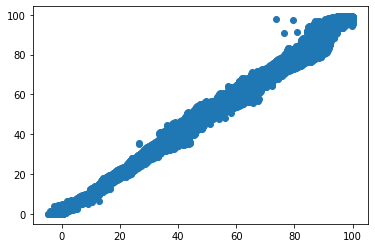

In [36]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<2 or actual[iter]>98:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 1):
    correct+=1


print(correct)
print(len(actual))

#print("Precision: ", correct * 100/len(actual))

Text(0.5, 1.0, 'Actual vs Prediction')

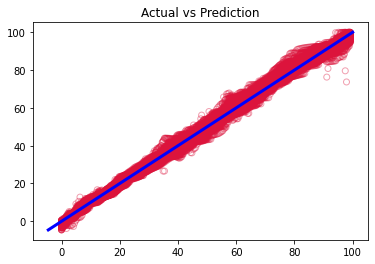

In [37]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

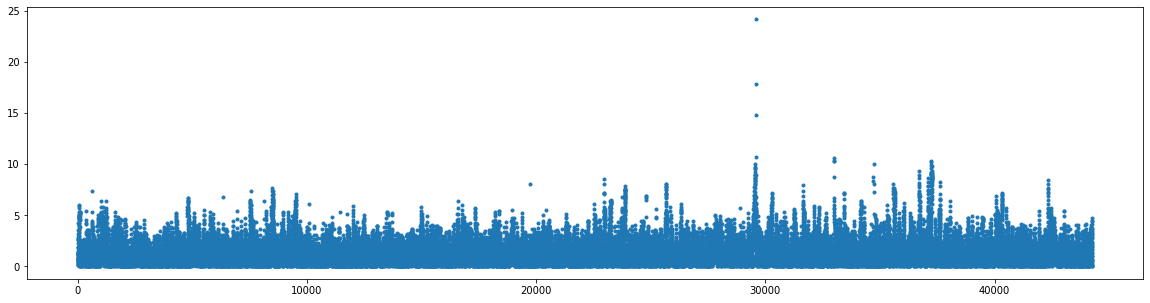

In [38]:
predfig=plt.figure(figsize=(20,5))
dif = abs(actual-pred)

plt.plot(dif,'.')


In [39]:
data_dif = pd.DataFrame(pred)
print(data_dif.to_string())

               0
0      66.718693
1      66.721625
2      67.392114
3      68.300733
4      69.453082
5      69.744974
6      71.159888
7      72.974357
8      72.662939
9      72.166891
10     72.447337
11     73.358813
12     73.332368
13     73.309382
14     73.286938
15     73.265034
16     73.243822
17     73.223264
18     73.203307
19     73.188669
20     73.179520
21     73.191527
22     73.216253
23     73.418771
24     73.829146
25     74.255287
26     74.696948
27     75.157062
28     75.634912
29     76.129375
30     76.638935
31     77.161723
32     77.690913
33     78.213904
34     78.744203
35     79.276260
36     82.106583
37     85.036784
38     85.714116
39     85.886037
40     86.233208
41     86.522699
42     86.140326
43     87.140288
44     88.784974
45     89.242940
46     89.279621
47     89.312574
48     89.342031
49     89.368259
50     89.391567
51     89.412247
52     89.462531
53     89.556649
54     89.643253
55     89.723106
56     89.797591
57     89.8656

In [40]:
strike = pd.DataFrame(x_test[:,-1])
print(strike.to_string())

           0
0      174.0
1      175.0
2      176.0
3      177.0
4      178.0
5      179.0
6      180.0
7      181.0
8      182.0
9      183.0
10     184.0
11     185.0
12     186.0
13     187.0
14     188.0
15     189.0
16     190.0
17     191.0
18     192.0
19     193.0
20     194.0
21     195.0
22     196.0
23     197.0
24     198.0
25     199.0
26     200.0
27     201.0
28     202.0
29     203.0
30     204.0
31     205.0
32     206.0
33     207.0
34     208.0
35     209.0
36     210.0
37     211.0
38     212.0
39     213.0
40     214.0
41     215.0
42     216.0
43     217.0
44     218.0
45     219.0
46     220.0
47     221.0
48     222.0
49     223.0
50     224.0
51     225.0
52     226.0
53     227.0
54     228.0
55     229.0
56     230.0
57     231.0
58     232.0
59     233.0
60     234.0
61     235.0
62     236.0
63     237.0
64     238.0
65     239.0
66     240.0
67     241.0
68     242.0
69     243.0
70     244.0
71     245.0
72     246.0
73     247.0
74     248.0
75     249.0

In [41]:
x_test[19111][-1]

70.0

In [42]:
#model_save_path="/content/drive/MyDrive/nmchr_lab/models/model_encoder_decoder_MS"

#encoder_decoder.save(model_save_path)

In [43]:
mlp_model = Sequential()
mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=train_encoded.shape[1]))
mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

adam = optimizers.Adam(lr)
mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                352       
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
 dense_6 (Dense)             (None, 2)                 18        
                                                                 
Total params: 634
Trainable params: 634
Non-trainable params: 0
_________________________________________________________________
